# Optimisation des warehouses

## Import des modules et des données

In [2]:
from sklearn.cluster import KMeans
import folium
import pandas as pd
from edc import maps
from edc import processing
import branca.colormap as cm

%load_ext autoreload
%autoreload 2

In [3]:
df_orders_lines = pd.read_csv('..\data\intermediate_data\df_orders_lines.csv')
df_carte_point = pd.read_csv('..\data\intermediate_data\df_carte_point.csv')

df_cities = pd.read_csv("../data/cities.csv")
df_routes = pd.read_csv("../data/routes_v2.csv")
df_orders = pd.read_csv("../data/orders.csv")

CO2_per_km = 0.795

## Calcul des nouveaux warehouses

On utilise un kmeans pour segmenter le territoire en 5 en fonction des distances entre les villes et les délais de livraison. On récupère les centroïdes de ces clusters.

In [4]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_orders_lines[['lat_delivery','lng_delivery']],df_orders_lines.order_total_volume)
new_warehouse = pd.DataFrame(kmeans.cluster_centers_,columns=['lat','lng'])

In [5]:
df_orders_lines['new_warehouse'] = kmeans.labels_
df_orders_lines.rename(columns={'lat_delivery':'lat' , 'lng_delivery':'lng'},inplace=True)
new_warehouse['index_warehouse'] = new_warehouse.index

En noir les entrepôts actuels, en couleur les entrepôts optimaux.

In [6]:
m = folium.Map()

colormap = cm.LinearColormap(colors=['white','black'], vmin=df_carte_point.order_total_volume.min(),vmax=df_carte_point.order_total_volume.max())
colormap.caption = 'order total volume'

df_orders_lines.apply(lambda point : maps.plotDot(m,point,color=maps.colors[point.new_warehouse]), axis = 1)
m.add_child(colormap,name='order total volume')

#Set the zoom to the maximum possible
m.fit_bounds(m.get_bounds())

df_cities[df_cities.is_warehouse].apply(lambda point : maps.plotMarker(m,point,color='black'), axis = 1)
new_warehouse.apply(lambda point : maps.plotMarker(m,point,color = maps.colors[int(point.index_warehouse)],with_tooltip=None), axis = 1)

m

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
df_warehouses_LP = pd.DataFrame([
                                ['Montereau-sur-le-Jard',660000,30000000,17000 ],
                                ['Thillay',740000,41200000,23000],
                                ['Alpes',240000 , 27000000, 10000 ],
                                ['Côte dAzur',80000 , np.nan, 11000 ],
                                ['Annecy',13800 , np.nan, 7600 ]
                                ],
                                columns=['city','nb_colis_jour','investissement','surface'])
df_warehouses_LP

,city,nb_colis_jour,investissement,surface
0,Montereau-sur-le-Jard,660000,30000000.0,17000
1,Thillay,740000,41200000.0,23000
2,Alpes,240000,27000000.0,10000
3,Côte dAzur,80000,NaN,11000
4,Annecy,13800,NaN,7600


In [27]:
from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(np.array(df_warehouses_LP.nb_colis_jour).reshape(-1, 1) , np.array(df_warehouses_LP.investissement))

LinearRegression()

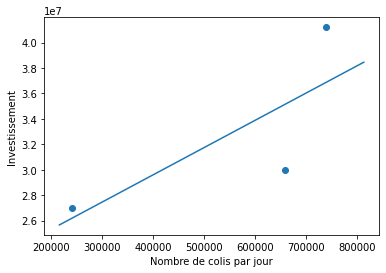

In [28]:
abs= np.linspace(int(df_warehouses_LP.nb_colis_jour.min()*.9),int(df_warehouses_LP.nb_colis_jour.max()*1.1))
plt.scatter(df_warehouses_LP.nb_colis_jour , df_warehouses_LP.investissement)
plt.plot(abs,linreg.predict(abs.reshape(-1, 1)))
plt.xlabel('Nombre de colis par jour')
plt.ylabel('Investissement');

In [29]:
linreg.predict(np.array([3000]).reshape(-1, 1))

array([21106303.14232902])

In [44]:
linreg_2 = linear_model.LinearRegression()
linreg_2.fit(np.array(df_warehouses_LP.nb_colis_jour).reshape(-1, 1) , np.array(df_warehouses_LP.surface))

LinearRegression()

In [45]:
linreg_2.predict(np.array([3000]).reshape(-1, 1))

array([8722.2093515])

In [47]:
linreg_2.predict(np.array([0]).reshape(-1, 1))

array([8699.73362541])

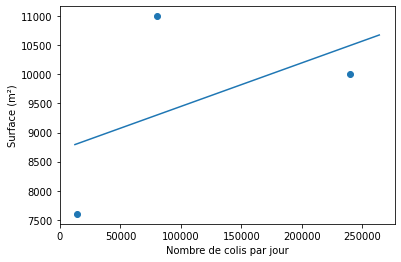

In [46]:
abs= np.linspace(int(df_warehouses_LP.nb_colis_jour.min()*.9),int(df_warehouses_LP.nb_colis_jour.max()*1.1))
plt.scatter(df_warehouses_LP.nb_colis_jour, df_warehouses_LP.surface)
plt.plot(abs,linreg_2.predict(abs.reshape(-1, 1)))
plt.xlabel('Nombre de colis par jour')
plt.ylabel('Surface (m²)');

In [ ]:
linreg_2.predict()

In [41]:
linreg_f = linear_model.LinearRegression()
linreg_f.fit(df_warehouses_LP.drop(columns=['investissement','city']) , df_warehouses_LP.investissement)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [12]:
df_orders.set_index(['order_date']).groupby('from_warehouse').sum() / (365/2)

,package_volume,n_units,order_total_volume
from_warehouse,,,
Avignon,19.521484,967.917808,471.693407
Cergy,56.939610,2742.158904,1358.291128
Clermont-Ferrand,5.339161,273.024658,133.279267
Montauban,12.025807,590.213699,291.587706
Reims,15.614838,751.654795,370.914610


In [13]:
cout_nouveau_warehouse = 0
vente_warehouse = 0

In [14]:
from edc import utils

In [15]:
df_routes["stops_list"] = df_routes.stops.apply(lambda row : row.split(' > '))
df_routes.drop(columns=['stops'],inplace=True)

In [15]:
n_trajets = 100

## Scénario 0

On fait rien

In [16]:
int(df_routes.sample(n_trajets,random_state=42).total_distance.sum()* CO2_per_km)

32606

In [17]:
from edc import optimisation
df_routes_optimized_0_small = df_routes.sample(n_trajets,random_state=42)
df_routes_optimized_0_small['stops_list_ordonnee_f'] = df_routes_optimized_0_small.apply(lambda row :optimisation.optimiser_trajectoire(utils.remove_consecutive_duplicate([utils.donnees_cities_with_name(row.from_warehouse)]+[utils.donnees_cities_with_name(city) for city in row.stops_list])),axis=1)
df_routes_optimized_0_small['total_distance_f'] = df_routes_optimized_0_small.apply(lambda row : utils.total_distance_trip([row.from_warehouse]+row.stops_list_ordonnee_f), axis=1)

In [18]:
int(df_routes_optimized_0_small.total_distance_f.sum()* CO2_per_km)

38623

## Scénario 1

On supprime l'entrepôt de Clermont-Ferrant

In [19]:
df_cities_1 = pd.read_csv("../data/cities.csv")
liste_warehouses_1 = ['Cergy','Reims','Avignon','Montauban']
df_warehouse_1 = df_cities[df_cities.city.isin(liste_warehouses_1)]
df_warehouse_1.index = np.arange(0,len(df_warehouse_1))


In [20]:
df_cities_1["warehouse"] = df_cities_1.city.apply(lambda row : processing.find_closest_warehouse(row,liste_warehouses_1))
df_cities_1["index_warehouse"] = df_cities_1.city.apply(lambda row : processing.find_closest_warehouse(row,liste_warehouses_1,return_index=True))
df_warehouse_1['index_warehouse'] = df_warehouse_1.index.copy()

d:\Documents\Cours\3A\M2AD\Novembre\edc_ekimetrics\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
m = folium.Map()

df_cities_1.apply(lambda point : maps.plotDot(m,point,color=maps.colors[point.index_warehouse],with_tooltip=False), axis = 1)

#Set the zoom to the maximum possible
m.fit_bounds(m.get_bounds())

df_warehouse_1.apply(lambda point : maps.plotMarker(m,point,color = maps.colors[int(point.index_warehouse)]), axis = 1)

m

In [22]:
df_routes_separate_1_small = processing.try_scenario(df_cities_1,df_routes=df_routes.sample(n_trajets,random_state=42))
int(df_routes_separate_1_small.total_distance_f.sum()* CO2_per_km)

47167

In [23]:
df_routes_separate_optimized_1_small = processing.try_scenario(df_cities_1,df_routes=df_routes.sample(n_trajets,random_state=42),with_optim=True)
int(df_routes_separate_optimized_1_small.total_distance_f.sum()* CO2_per_km)

42992

## Scénario 2

On déplace 1 entrepôt : celui de Clermont-Ferrant à Rennes

In [24]:
df_cities_2 = pd.read_csv("../data/cities.csv")
liste_warehouses_2 = ['Cergy','Reims','Avignon','Montauban','Rennes']

In [25]:
df_warehouse_2 = df_cities[df_cities.city.isin(liste_warehouses_2)]
df_warehouse_2.index = np.arange(0,len(df_warehouse_2))

df_cities_2["warehouse"] = df_cities_2.city.apply(lambda row : processing.find_closest_warehouse(row,liste_warehouses_2))
df_cities_2["index_warehouse"] = df_cities_2.city.apply(lambda row : processing.find_closest_warehouse(row,liste_warehouses_2,return_index=True))
df_warehouse_2['index_warehouse'] = df_warehouse_2.index.copy()

d:\Documents\Cours\3A\M2AD\Novembre\edc_ekimetrics\venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
m = folium.Map()

df_cities_2.apply(lambda point : maps.plotDot(m,point,color=maps.colors[point.index_warehouse],with_tooltip=False), axis = 1)
df_warehouse_2.apply(lambda point : maps.plotMarker(m,point,color = maps.colors[int(point.index_warehouse)]), axis = 1)

m.fit_bounds(m.get_bounds())
m

In [27]:
df_routes_separate_2_small = processing.try_scenario(df_cities_2,df_routes=df_routes.sample(n_trajets,random_state=42))
int(df_routes_separate_2_small.total_distance_f.sum()* CO2_per_km)

43581

In [28]:
df_routes_separate_optimized_2_small = processing.try_scenario(df_cities_2,df_routes=df_routes.sample(n_trajets,random_state=42),with_optim=True)
int(df_routes_separate_optimized_2_small.total_distance_f.sum()* CO2_per_km)

41482

## Scénario 3

On déplace 2 entrepôts : celui de Clermont-Ferrant à Rennes, et celui de Reims à Mulhouse

In [29]:
df_cities_3 = pd.read_csv("../data/cities.csv")

liste_warehouses_3 = ['Cergy','Mulhouse','Avignon','Montauban','Rennes']
df_warehouse_3 = df_cities[df_cities.city.isin(liste_warehouses_3)]
df_warehouse_3.index = np.arange(0,len(df_warehouse_3))
df_warehouse_3['index_warehouse'] = df_warehouse_3.index 

df_cities_3["warehouse"] = df_cities_3.city.apply(lambda row : processing.find_closest_warehouse(row,liste_warehouses_3))
df_cities_3["index_warehouse"] = df_cities_3.city.apply(lambda row : processing.find_closest_warehouse(row,liste_warehouses_3,return_index=True))

d:\Documents\Cours\3A\M2AD\Novembre\edc_ekimetrics\venv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
df_cities_3.loc[df_cities_3.city=='Annecy', 'warehouse'] = 'Avignon'
df_cities_3.loc[df_cities_3.city=='Annecy', 'index_warehouse'] = 2

df_cities_3.loc[df_cities_3.city=='Perpignan', 'warehouse'] = 'Avignon'
df_cities_3.loc[df_cities_3.city=='Perpignan', 'index_warehouse'] = 2

In [31]:
m = folium.Map()

df_cities_3.apply(lambda point : maps.plotDot(m,point,color=maps.colors[point.index_warehouse],with_tooltip=False), axis = 1)
df_warehouse_3.apply(lambda point : maps.plotMarker(m,point,color = maps.colors[int(point.index_warehouse)]), axis = 1)

m.fit_bounds(m.get_bounds())
m

In [32]:
df_routes_separate_3_small = processing.try_scenario(df_cities_3,df_routes=df_routes.sample(n_trajets,random_state=42))
int(df_routes_separate_3_small.total_distance_f.sum()* CO2_per_km)

43364

In [33]:
df_routes_separate_optimized_3_small = processing.try_scenario(df_cities_3,df_routes=df_routes.sample(n_trajets,random_state=42),with_optim=True)
int(df_routes_separate_optimized_3_small.total_distance_f.sum()* CO2_per_km)

41859